In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
N = 800
T = 1.0 / 800.0

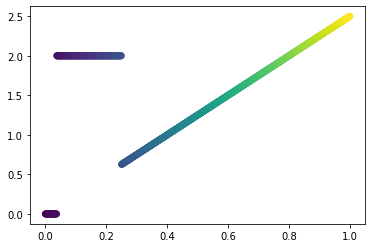

In [4]:
def create_function_data(nums_data, if_plot= False):
    """
    Create data for linear model
    Args:
        nums_data: how many data points that wanted
    Returns:
        x with shape (nums_data, 1)
    """
    x = torch.linspace(0, 1, nums_data)
    x = torch.unsqueeze(x, dim=1)
    
    y = 2*torch.sin(2*np.pi*x+1.2) + torch.sin(35*np.pi*x+2.3)
    
    y[:30] = 0
    y[30:200] = -5
    y[280:300] = 2
    #y[200:300] = 2
    y[300:] = 1
    
    y[:30] = 0
    y[30:200] = 2
    y[200:] = 2.5*x[200:]
    
    #y = (x*nums_data) % 2

    y = torch.reshape(y, (800,1))
    
    if if_plot:
        plt.scatter(x.numpy(), y.numpy(), c=x.numpy())
        plt.show()
    data = {"x":x, "y":y}
    return data

data = create_function_data(N, if_plot=True)

In [5]:
frequency_points = 50

class DFTRegression(torch.nn.Module):
    """
    DFT Regressoin Module
    """
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, frequency_points)
        self.fc2 = torch.nn.Linear(1, frequency_points)
        
    def forward(self, x):
        dummy = torch.ones(1).to(dev)
        dummy = torch.unsqueeze(dummy, dim=1)
        
        real = self.fc1(dummy)
        imag = self.fc2(dummy)        
        cplx = torch.complex(real, imag)
        
        pts = torch.tensor([i for i in range(frequency_points)], dtype=torch.float32).to(dev)
        
        out = torch.reshape(torch.sum(2.0/N*torch.abs(cplx)*torch.cos(pts/(N*T)*2.0*np.pi*x+torch.angle(cplx)), dim=1), (N,1))
        
        return out

In [6]:
class DFT_Model():
    def __init__(self):
        """
        Initialize the DFT 1D Model
        """
        self.learning_rate = 100
        self.epoches = 10000
        self.loss_function = torch.nn.MSELoss()
        self.create_model()
        
    def create_model(self):
        self.model = DFTRegression().to(dev)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
    
    def train(self, data, model_save_path="model.pth"):
        """
        Train the model and save the parameters
        Args:
            model_save_path: saved name of model
            data: (x, y) = data
        Returns: 
            None
        """
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        for epoch in range(self.epoches):
            prediction = self.model(x)
            loss = self.loss_function(prediction, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % 500 == 0:
                print("epoch: {}, loss is: {}".format(epoch, loss.item()))
        torch.save(self.model.state_dict(), "dft.pth")      
        
    def test(self, x, model_path="dft.pth"):
        """
        Reload and test the model, plot the prediction
        Args:
            model_path: the model's path and name
            data: (x, y) = data
        Returns:
            None
        """
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        self.model.load_state_dict(torch.load(model_path))
        prediction = self.model(x)
        
        plt.scatter(x.cpu().numpy(), y.cpu().numpy(), c='b')
        plt.plot(x.cpu().numpy(), prediction.detach().cpu().numpy(), color="r")
        plt.show()
        
    def compare_epoches(self, data):
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        
        num_pictures = 16
        fig = plt.figure(figsize=(10,10))
        current_fig = 0
        for epoch in range(self.epoches):
            prediction = self.model(x)
            loss = self.loss_function(prediction, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if epoch % (self.epoches/num_pictures) == 0:
                current_fig += 1
                plt.subplot(4, 4, current_fig)
                plt.scatter(x.cpu().numpy(), y.cpu().numpy(), c='b')
                plt.plot(x.cpu().numpy(), prediction.detach().cpu().numpy(), color="r")
        plt.show()

epoch: 0, loss is: 2.900848865509033
epoch: 500, loss is: 0.3191787600517273
epoch: 1000, loss is: 0.058434199541807175
epoch: 1500, loss is: 0.022908397018909454
epoch: 2000, loss is: 0.015935828909277916
epoch: 2500, loss is: 0.014200493693351746
epoch: 3000, loss is: 0.013724775984883308
epoch: 3500, loss is: 0.013590233400464058
epoch: 4000, loss is: 0.013551824726164341
epoch: 4500, loss is: 0.013540827669203281
epoch: 5000, loss is: 0.013537689112126827
epoch: 5500, loss is: 0.01353677362203598
epoch: 6000, loss is: 0.013536512851715088
epoch: 6500, loss is: 0.01353644672781229
epoch: 7000, loss is: 0.013536441139876842
epoch: 7500, loss is: 0.013536427170038223
epoch: 8000, loss is: 0.013536420650780201
epoch: 8500, loss is: 0.01353640016168356
epoch: 9000, loss is: 0.013536415994167328
epoch: 9500, loss is: 0.013536416925489902


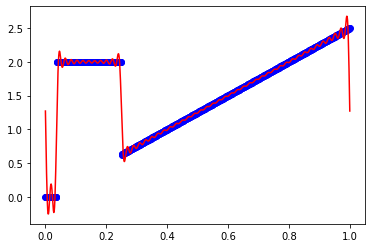

In [7]:
dft = DFT_Model()
data = create_function_data(N)
dft.train(data)
dft.test(data)

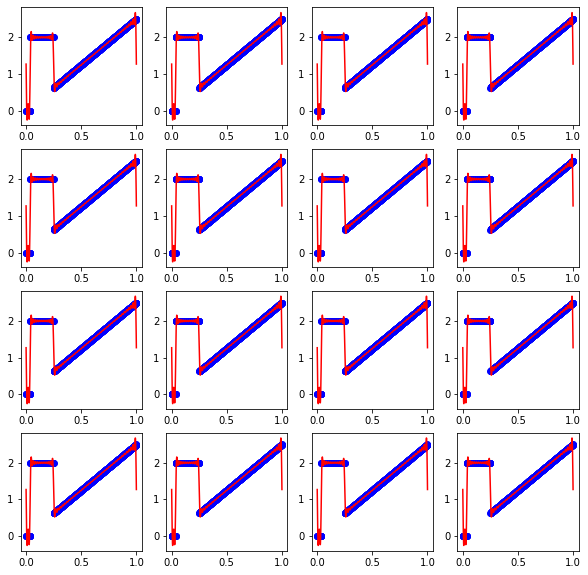

In [8]:
dft.compare_epoches(data)